* Arman Khalatyan (arm2arm) & Friedrich Anders (fjaellet) 2021
* Last mod: FA 11 Feb 2022

# Accessing StarHorse 2021 datasets

This notebook demonstrates how you can access the StarHorse2021 data in python.
The first shows how you can access the summary tables (using the median output values dist50, AV50, etc.); below we show how to extract the full posterior approximations for a given object.

## 1. Plotting top 100K stars from the database

To do this, we connect to the gaia.aip.de server via pyvo. We define the following utility function:

* **get_one_query**: run a single query on gaia.aip.de using TAP serivce

In [1]:
import requests
import pyvo as vo
import os
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import h5py
import s3fs
import corner
import requests

# run a single postgre sql query using API key
# usage: get_one_query("select * from gaiaedr3_contrib.source_id2split limit 10")
# it returns pandas dataframe
def get_one_query(qstr,verbose=False):
    name = 'GAIA@AIP'
    url = 'https://gaia.aip.de/tap'
    # You can also use your TAP API Token from the gaia.aip.de account: gaia.aip.de->RightUpperMenu->API token
    token = "" #"Token XXX"


    if verbose:
        print('\npyvo version %s \n' % vo.__version__)
        print('TAP service %s \n' % name)

    # Setup authorization
    tap_session = requests.Session()
    tap_session.headers['Authorization'] = token

    jobs = []
    # open the connection
    tap_service = vo.dal.TAPService(url, session=tap_session)
    job = tap_service.submit_job(qstr, language='postgresql', runid='pybatch',queue="2h")
    job.run()
    jobs.append(job)
    i=0
    dfvec=[]
    for job in jobs:
        if verbose: print('getting results:',i)

        if verbose: print('getting results from ' + str(job.job.runid))
        job.raise_if_error()

        job.wait(phases=["COMPLETED", "ERROR", "ABORTED"], timeout=10.)
        if verbose:print(str(job.job.runid) + ' ' + str(job.phase))

        if job.phase in ("ERROR", "ABORTED"):
            pass
        else:
            results = job.fetch_result()
            dfvec.append(results.to_table().to_pandas())
        i=i+1
    return pd.concat(dfvec)

Now we can launch an ADQL query to get the first 100k stars from the database:

In [2]:
# Load data from gaia.aip.de
qstr = f'select  * from gaiaedr3_contrib.starhorse as s limit 100000'
df=get_one_query(qstr)
df["logteff"]=np.log10(df["teff50"])

And make some nice plots:

<AxesSubplot:xlabel='logteff', ylabel='logg50'>

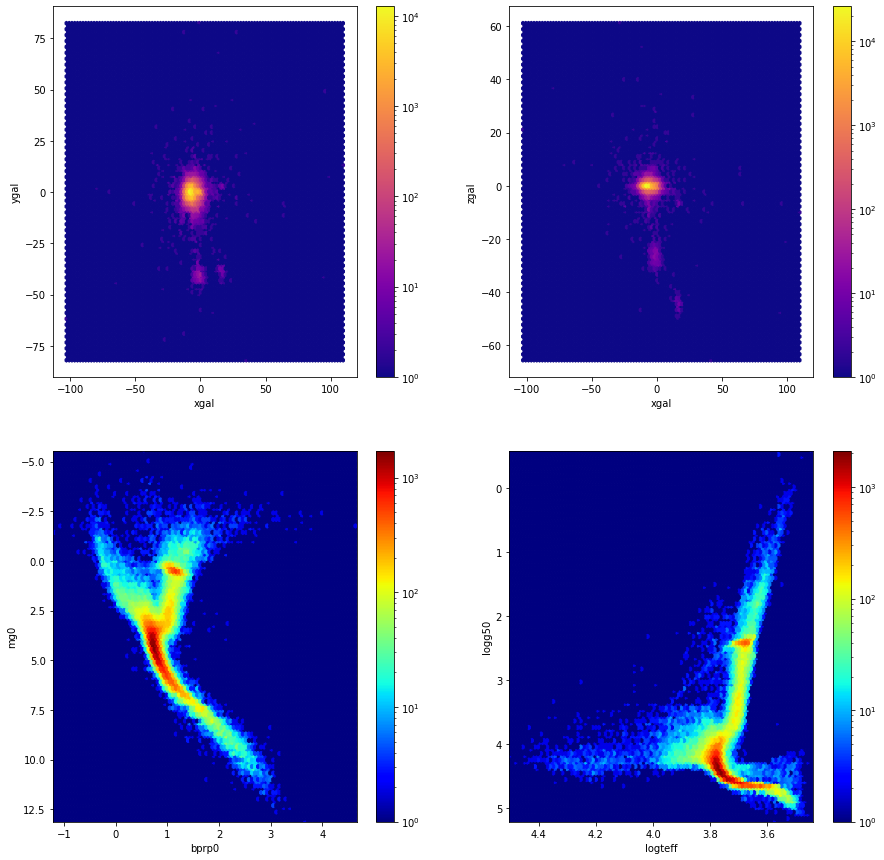

In [3]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
df.plot(x='xgal',y='ygal',kind='hexbin',norm=mpl.colors.LogNorm(),cmap="plasma",ax=axs[0,0])
df.plot(x='xgal',y='zgal',kind='hexbin', norm=mpl.colors.LogNorm(),cmap="plasma",ax=axs[0,1])
df.plot(x='bprp0',y='mg0',kind='hexbin', xlim=[np.min(df["bprp0"]),np.max(df["bprp0"])],ylim=[np.max(df["mg0"]),np.min(df["mg0"])], norm=mpl.colors.LogNorm(),cmap="jet", ax=axs[1,0])
df.plot(x='logteff',y='logg50',kind='hexbin', xlim=[np.max(df["logteff"]),np.min(df["logteff"])],ylim=[np.max(df["logg50"]),np.min(df["logg50"])], norm=mpl.colors.LogNorm(),cmap="jet", ax=axs[1,1])

## 2. Getting the full PDF (approximated by a Gaussian Mixture Model) for a given source_id

Since the data are not stored by Healpix, but in random chunks, we first need to define two more utility functions:

* **source_id2split**: a small routine to link: source_id to PDF files(should not be used directly)
* **pdf_plot_by_id**: plotting routine for a single PDF for the star with a source_id
  * locate by source_id2split the file names
  * load raw PDF data from S3 storage hosted at AIP
  * load SH out in TXT format, used for the blue vertical marker to indicate what SH was finding as a value
  * make a corner plots.

In [4]:
# locate stellar split file by source_id
def source_id2split(source_id):
    split=""
    qstr = f'select * from gaiaedr3_contrib.source_id2split as s where s.source_id={source_id} limit 1'
    df=get_one_query(qstr)
    return df.split[0]

#  corner plot for a single star: f is a pdf h5 file data, f2 SH21 out data of a split
def pdf_plot_by_id(f,f2,iid):
    ndim, nsamples = 5, 100000
    np.random.seed(42)
    iikeys = np.int64(list(h5f.keys()))
    ii = [i for i,x in enumerate(iikeys) if x == source_id][0]
    iid = list(f.keys())[ii]
    example  = f[iid]
    # extract GMM from HDF5 files
    data1 = np.random.multivariate_normal(np.array(example['Gauss1_means']), np.array(example['Gauss1_covs']), size=int(example["weights"][0]*nsamples))
    data2 = np.random.multivariate_normal(np.array(example['Gauss2_means']), np.array(example['Gauss2_covs']), size=int(example["weights"][1]*nsamples))
    data3 = np.random.multivariate_normal(np.array(example['Gauss3_means']), np.array(example['Gauss3_covs']), size=int(example["weights"][2]*nsamples))
    samples = np.vstack([data1, data2, data3])
    # corner plot
    plt.figure(figsize=(8,8))
    figure = corner.corner(samples, plot_datapoints=False, show_titles=True, smooth=True,
                           labels=[r"$M_{\rm act}\ [M_{\odot}]$", r"Age [Gyr]", r"[Z/H]", "$d$ [kpc]", r"$A_V$ [mag]"],
                           range=[0.995, 0.995, 0.995, 0.995, 0.995], use_math_text=True, 
                           label_kwargs={"fontsize":25}, title_kwargs={"fontsize":22})
    # Get the median parameters from the SH output files
    values = f2[f2["ID"]==np.int64(iid)][["mass50", "age50", "met50", "dist50", "AV50"]].values[0]
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(values[i], color="b")

    figure.subplots_adjust(right=1.5,top=1.5)
    for ax in figure.get_axes():
        ax.tick_params(axis='both', labelsize=16)
    #plt.suptitle(r'source_id '+ iid, fontsize=20)
    ax = axes[1, 1]
    plt.text(3., 1.5, r'source_id '+ iid, horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes)
    plt.savefig("img/corner-" + iid +"png", dpi=100, bbox_inches="tight")


Now we can choose an interesting object and proceed to plotting its posterior. 
First get the summary data:

In [5]:
source_id=526910883482240
qstr = f'select  * from gaiaedr3_contrib.starhorse as s where s.source_id={source_id}'
df=get_one_query(qstr)
list(df.columns)
df

,source_id,dist05,dist16,dist50,dist84,dist95,av05,av16,av50,av84,...,bprp0,mg0,xgal,ygal,zgal,rgal,fidelity,bp_rp_excess_corr,sh_photoflag,sh_outflag
0,526910883482240,1.8981,2.069672,2.079017,2.119607,2.768293,0.201813,0.2029,0.207748,0.287606,...,0.850055,5.501841,-9.591359,0.13608,-1.538803,9.592324,0.980957,0.006153,GBPRPgrizy/grizJHKsW1W2,0000


### And now get and plot the PDF:

In [6]:
# First we should locate the star on the S3 storage

fmask=source_id2split(source_id)

filename1=f"s3://sh21pdf/gaiaedr3_sh_input_healpixlevel5_hpno-{fmask}.fits.hdf5.h5"
filename2=f"https://s3.data.aip.de:9000/sh21pdf/gaiaedr3_sh_input_healpixlevel5_hpno-{fmask}.fits.hdf5.txt"

#prevent the multiple hanging open files
if 'x' in vars():
    try:
        fs.close()
        h5f.close()
    except:
        pass # Was already closed
# connect to public Bucket
fs= s3fs.S3FileSystem(anon=True,client_kwargs={'endpoint_url':"https://s3.data.aip.de:9000"})

h5file=fs.open(filename1)
h5f=h5py.File(h5file, 'r')
source_ids=list(h5f.keys())
# get remote SH21 split OUT data 
dfsh=pd.read_csv(StringIO(requests.get(filename2).content.decode('utf-8')),delimiter="\s+",dtype={'#ID': 'int64'}).rename(columns={"#ID": "ID"})


<Figure size 576x576 with 0 Axes>

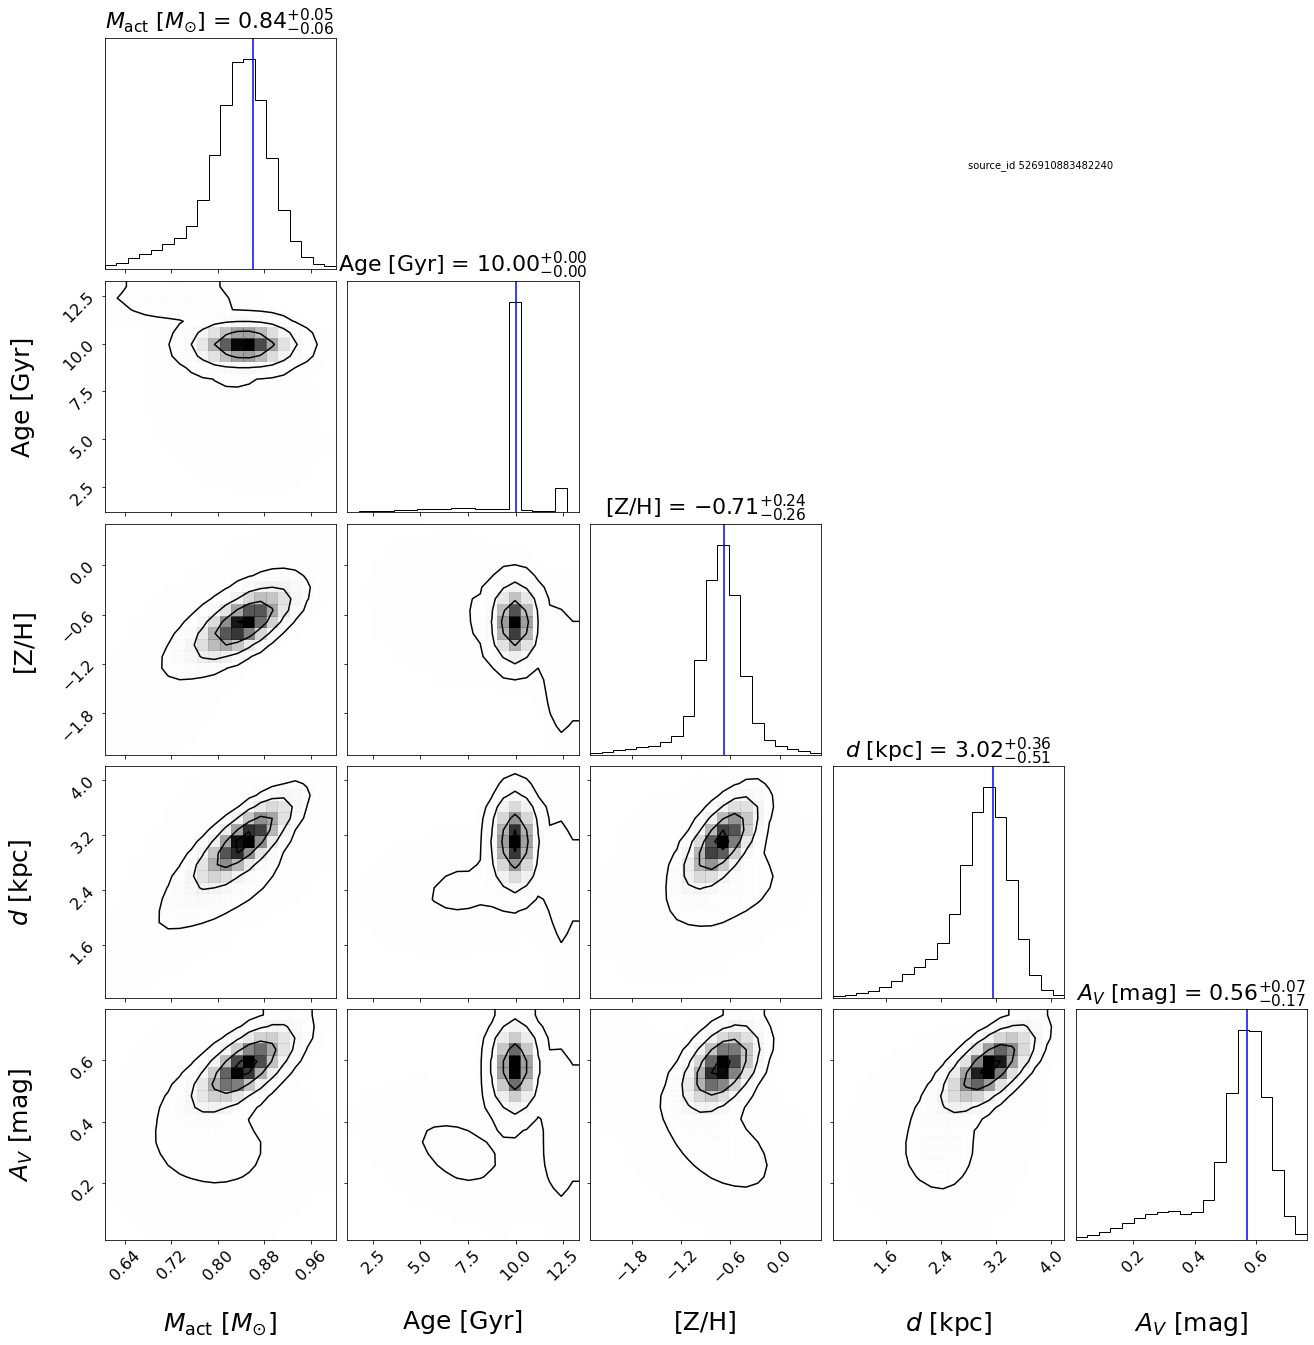

In [7]:
pdf_plot_by_id(h5f,dfsh,source_id)